# Library import

In [1]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

#import keras

NUM_CLASSES = 5  #how many different type of class/type of image you are using. Like CAT,DOG, ELEPHANT etc
IMG_SIZE = 48  # You can change it. Always keep same size for width and height. That means square size.

Using TensorFlow backend.


# Function for preprocessing image. Able for RGB & Gray Image

In [2]:
#for gray scale
def preprocess_img(img):
    # Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])

# Store the image and label in array. Run this cell if you need to do training. For testing no need to run it

In [3]:
imgs = []
labels = []
root_dir = '/home/atif/training_by_several_learning_process/flower_photos/flower_train_images/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.jpg')) #I have done the training with .ppm format image. If another type of image will come 
                                                                                    #them .ppm will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

X = np.array(imgs, dtype='float32') #Keeping the image as an array
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels] #labels of the image


/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processed 1000/3673
Processed 2000/3673
Processed 3000/3673


(3673, 48, 48)
(3673, 1, 48, 48)
4
(1, 48, 48)


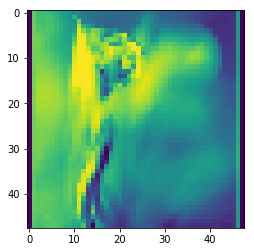

In [7]:
X = np.array(imgs, dtype='float32')
print(X.shape)
# plt.imshow(X[0])
# plt.imshow(X[0],cmap="gray")
plt.imshow(X[0]) #if you use this command here you will see something coloured image. No problem, it is gray image. 
                        #To see full Black and white image uncomment the previous line.
X = X.reshape(len(imgs),1,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# plt.imshow(X[0],cmap="gray")
print(X.shape)
print(X.ndim)
print(X[0].shape)

In [8]:
print(X.shape)
print(Y.shape)

(3673, 1, 48, 48)
(3673, 5)


# making a model. Run it for training and testing

In [9]:
# This model is for understanding the inner calculation of CNN that's why I have started witha minimal layer as well as model.
# Increase the filter number and layer if you want a good result
#Conv2D(1, (3, 3) >> here 1 = number of filter. (3,3) = kernel height and width
# you can just add padding just beside Conv2D. (model.add(Conv2D(1,(3,3)),padding='same',....))
# I haven't added here for remove complexity in c++(I have tried to implement this whole model in testing phase in cpp)
def cnn_model():
#      padding='same'
    model = Sequential()

    model.add(Conv2D(1, (3, 3),
                     input_shape=(1,IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 46, 46)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2116)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10585     
Total params: 10,595
Trainable params: 10,595
Non-trainable params: 0
_________________________________________________________________


# Training phase. Storing the model also for further use

In [12]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 5
model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint('/home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/gray_flower_ep_5_ch_1.h5', save_best_only=True)])

Train on 2938 samples, validate on 735 samples
Epoch 1/5
2938/2938 [==============================] - 1s 437us/step - loss: 1.6000 - acc: 0.2645 - val_loss: 1.5839 - val_acc: 0.2735
Epoch 2/5
2938/2938 [==============================] - 1s 300us/step - loss: 1.5505 - acc: 0.3176 - val_loss: 1.5603 - val_acc: 0.3048
Epoch 3/5
2938/2938 [==============================] - 1s 293us/step - loss: 1.4775 - acc: 0.3659 - val_loss: 1.5558 - val_acc: 0.3048
Epoch 4/5
2938/2938 [==============================] - 1s 285us/step - loss: 1.4011 - acc: 0.4214 - val_loss: 1.5699 - val_acc: 0.3129
Epoch 5/5
2938/2938 [==============================] - 1s 281us/step - loss: 1.3108 - acc: 0.4789 - val_loss: 1.6717 - val_acc: 0.2776


# testing image

In [13]:
from keras.models import load_model
model = load_model('/home/atif/training_by_several_learning_process/flower_photos/train_model_flower/flw_gray_ch_1_ep_100_no_pad_relu_31_dec.h5')
#for gray scale
def preprocess_img(img):
#     Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

import glob

path = r'/home/atif/training_by_several_learning_process/flower_photos/flower_test_image/'

img_path = glob.glob(path+ '/*.jpg')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),1,IMG_SIZE,IMG_SIZE)
    
    print("\n",image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
    
    probability = model.predict_proba(X_test)
    print("probability: ",probability)


 /home/atif/training_by_several_learning_process/flower_photos/flower_test_image/test_im.jpg
predicted class:  [1]
probability:  [[0.17829023 0.23963664 0.18002798 0.18576029 0.21628486]]


/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 1, 48, 48)
4
(48, 48)


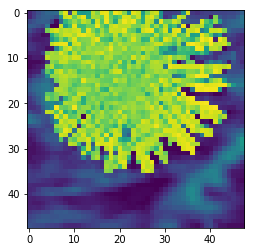

In [16]:
print(X_test.shape)
print(X_test.ndim)
# plt.imshow(X_test[0])
X_test_show = X_test.reshape(IMG_SIZE,IMG_SIZE) # Need if you want to see the image
print(X_test_show.shape)
plt.imshow(X_test_show) # Displaying the image

# extracting the weight from trained model

In [12]:
from keras.models import load_model
import pandas as pd
model = load_model('/home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/gray_flower_ep_5_ch_1.h5')
x_list=[]
layer_list =[]
i=0
for layer in model.layers:
    g=layer.get_config()
    h=layer.get_weights()
    
    layer_list.append(h)
    i=i+1
    print ("g== ",g,"\n")

    print ("h== ",h,"\n\n")
    #print("type_of g == ",type(g),"\n")
    #print("type_of h == ",type(h),"\n")
layer_name=['conv_layer','flatten_layer','dense_layer']
        
conv_kernel=layer_list[0][0]
conv_kernel=conv_kernel.transpose()
print("conv_kernel: \n",conv_kernel,"\n\n")
print("conv_kernel shape:\t",conv_kernel.shape,"\n\n")
print("conv kernel dimension:\t",conv_kernel.ndim,"\n\n")
print("type_conv_kernel:",type(conv_kernel),"\n")
#conv_kernel_reshape=conv_kernel.reshape(conv_kernel[3],conv_kernel[2],conv_kernel[1],conv_kernel[0])
#print("re:  ",conv_kernel_reshape.shape)

conv_bias=layer_list[0][1]
print("conv_bias_value: ",conv_bias)
print("conv_bias ndim: ",conv_bias.ndim,"\n\n")

dense_kernel=layer_list[2][0]
# conv_kernel=conv_kernel.transpose()
print("dense_kernel: \n",dense_kernel,"\n\n")
print("dense_kernel shape:\t",dense_kernel.shape,"\n\n")
print("dense_kernel dimension:\t",dense_kernel.ndim,"\n\n")
print("type_dense_kernel:",type(dense_kernel),"\n")
print("dense_kernel size: ",dense_kernel.size,"\n")
# dense_1_transpose=dense__1.transpose()
# print("dense_1_transpose: ",dense_1_transpose,"\n\n")


dense_bias=layer_list[2][1]
print("dense_bias: ",dense_bias)
print("dense_bias_shape: ",dense_bias.shape)
dense_bias=dense_bias.reshape(1,5)
print("dense_bias_shape: ",dense_bias.shape)
# print(dense_2[0])

g==  {'name': 'conv2d_1', 'trainable': True, 'batch_input_shape': (None, 1, 48, 48), 'dtype': 'float32', 'filters': 1, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_first', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} 

h==  [array([[[[-0.03033464]],

        [[ 0.23801574]],

        [[-0.56720567]]],


       [[[ 0.24555111]],

        [[-0.6949715 ]],

        [[-0.06389805]]],


       [[[-0.5152609 ]],

        [[ 0.05478185]],

        [[ 0.33108518]]]], dtype=float32), array([-0.35551634], dtype=float32)] 


g==  {'name': 'flatten_1', 'trainable': True, 'data_format': 'channels_first'} 
